In [1]:
import tensorflow as tf
import librosa
import numpy as np
from pydub import AudioSegment, effects
import noisereduce as nr

/opt/homebrew/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in model

In [4]:
# Load first model
saved_model_path = './ser_model.json'
saved_weights_path = './ser_model_weights.h5'

# Load new, better model
# saved_model_path = './goodmodel.json'
# saved_weights_path = './goodmodel_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)  # Assuming json_savedModel is defined
model.load_weights(saved_weights_path)
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

Preprocessing

In [2]:
import tensorflow as tf
import librosa
import numpy as np
from pydub import AudioSegment, effects
import noisereduce as nr

total_length = 173056 # desired frame length for all of the audio samples.
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
# Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    try:
        padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    except:
        print("error")
        print("file:", file)
        return None
    # normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(padded_x, sr=sr)
        
        
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f2, f1, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D

# file_path = './test_files/copy_OAF_fail_disgust.wav'  # Update with the path to your .wav file
# file_path = './own_recordings/rec12.wav'
file_path = './final_test/steven_happy_2.wav'

preprocessed_file = preprocess(file_path)

/opt/homebrew/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [102]:
predictions = model.predict(preprocessed_file)
np.set_printoptions(suppress=True)
print("---------")
print("File:", file_path)
print(predictions)

# Assuming your model outputs a softmax distribution over emotions
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
print(np.argmax(predictions))
predicted_emotion = emotions[np.argmax(predictions)]
print(f"Predicted emotion: {predicted_emotion}")

1/1 [==============================] - 0s 335ms/step
---------
File: ./final_test/steven_happy_2.wav
[[0.63394827 0.03548676 0.07065978 0.06334981 0.09052043 0.04056976
  0.02366421 0.04180102]]
0
Predicted emotion: neutral


### Workflow for processing multiple files at once

In [103]:
import os

preprocessed_files = []
preprocessed_files_names = []
directory = './final_test'
for file in os.listdir(directory):
    if '.DS_Store' in file:
      continue
    file_path = os.path.join(directory, file)
    processed_file = preprocess(file_path)
    if processed_file is not None:
        preprocessed_files.append(processed_file)
        preprocessed_files_names.append(file)

for i, f in enumerate(preprocessed_files):
    emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  

    predictions = model.predict(f)
    rounded_predictions = np.round(predictions[0], 3)
    # predictions_list = rounded_predictions.tolist()
    # print(predictions_list)
    np.set_printoptions(suppress=True)
    print("---------")
    print("File:", preprocessed_files_names[i])
    print(' '.join(f'{col:<8}' for col in emotions))
    print(' '.join(f'{str(val):<8}' for val in rounded_predictions))

    # Assuming your model outputs a softmax distribution over emotions
 
    print(np.argmax(predictions))
    predicted_emotion = emotions[np.argmax(predictions)]
    print(f"Predicted emotion: {predicted_emotion}")


1/1 [==============================] - 0s 34ms/step
---------
File: luke_sad_2.wav
neutral  calm     happy    sad      angry    fearful  disgust  surprised
0.008    0.018    0.003    0.936    0.0      0.025    0.005    0.004   
3
Predicted emotion: sad
1/1 [==============================] - 0s 26ms/step
---------
File: luke_happy_1.wav
neutral  calm     happy    sad      angry    fearful  disgust  surprised
0.063    0.013    0.249    0.305    0.004    0.326    0.014    0.026   
5
Predicted emotion: fearful
1/1 [==============================] - 0s 27ms/step
---------
File: luke_sad_1.wav
neutral  calm     happy    sad      angry    fearful  disgust  surprised
0.006    0.056    0.029    0.073    0.139    0.469    0.226    0.003   
5
Predicted emotion: fearful
1/1 [==============================] - 0s 24ms/step
---------
File: luke_happy_2.wav
neutral  calm     happy    sad      angry    fearful  disgust  surprised
0.41     0.072    0.152    0.124    0.061    0.081    0.032    0.067   
0

### Analysis of longer audio files by breaking them down

1/1 [==============================] - 0s 27ms/step


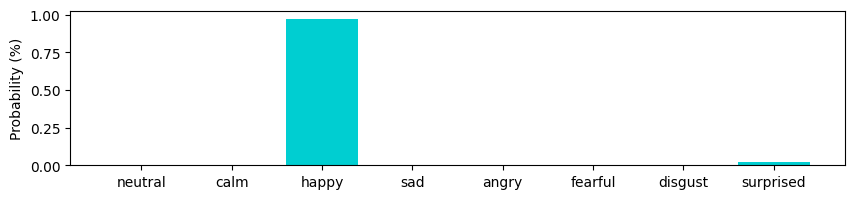

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 33ms/step


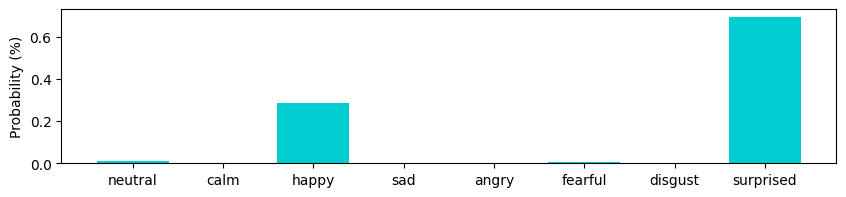

max emotion for chunk: surprised
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 38ms/step


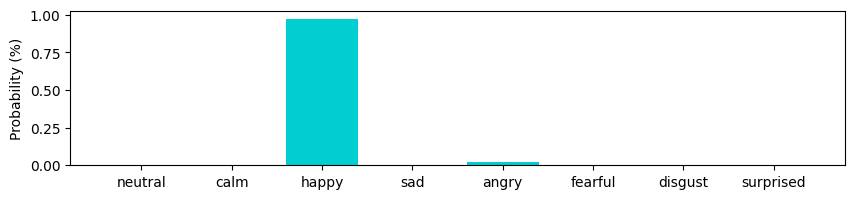

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step


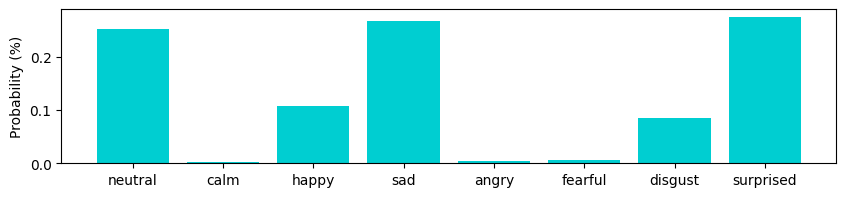

max emotion for chunk: surprised
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 36ms/step


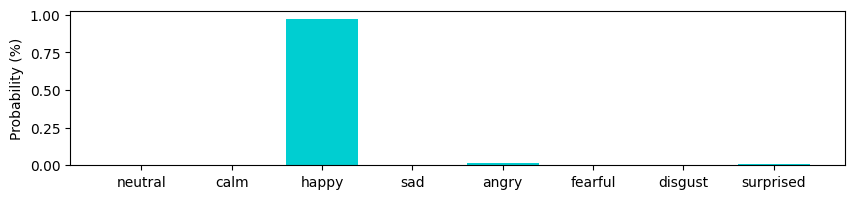

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step


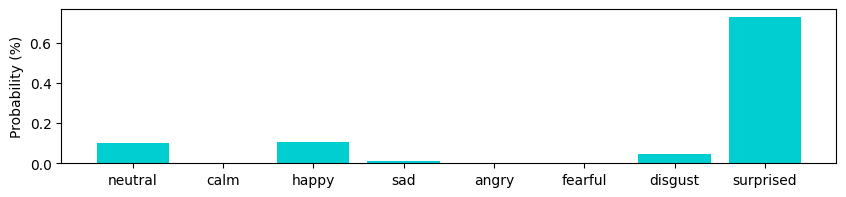

max emotion for chunk: surprised
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step


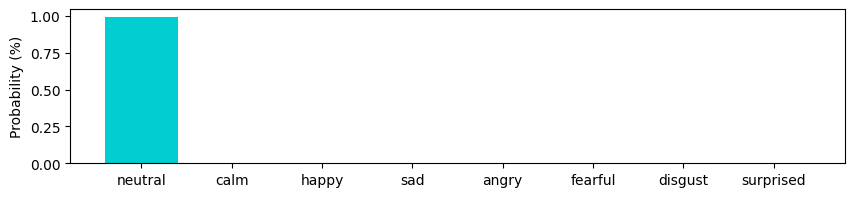

max emotion for chunk: neutral
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step


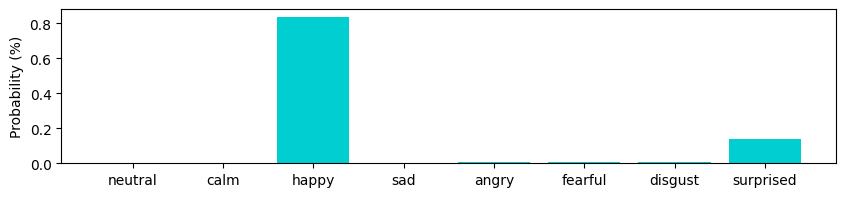

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 44ms/step


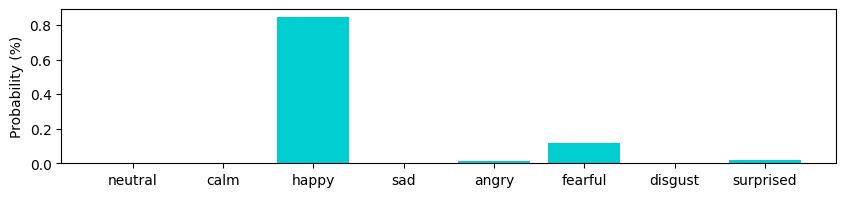

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 89ms/step


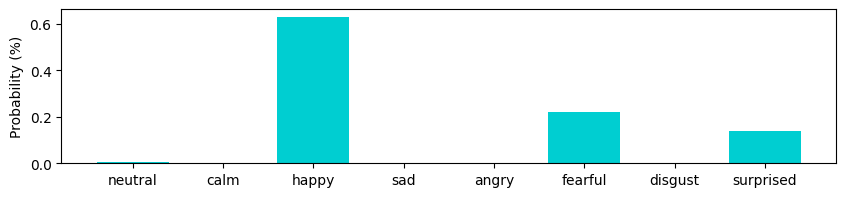

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step


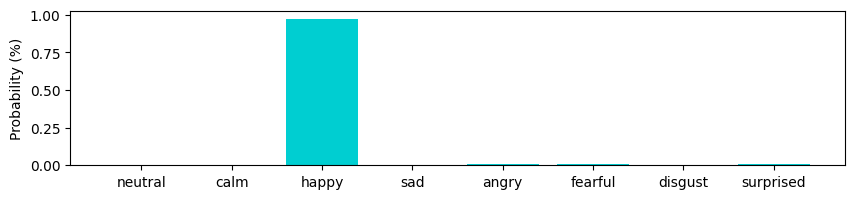

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 38ms/step


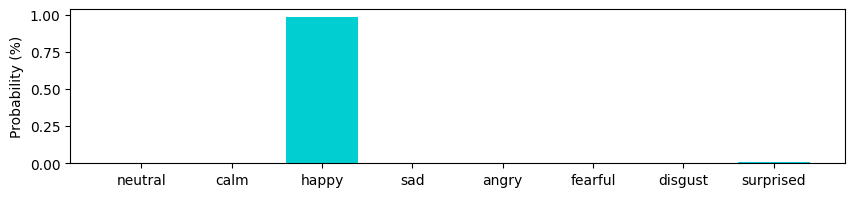

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 106ms/step


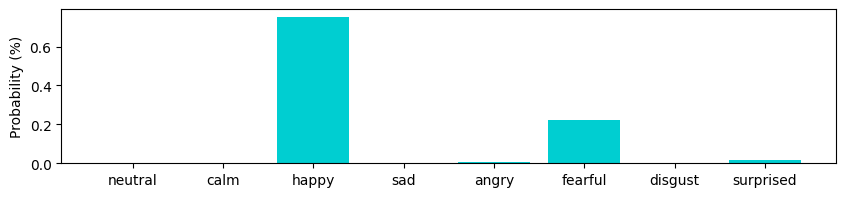

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step


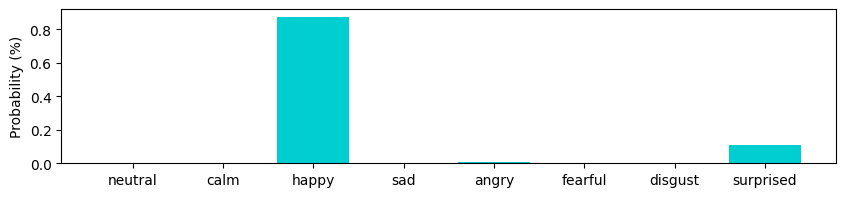

max emotion for chunk: happy
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step


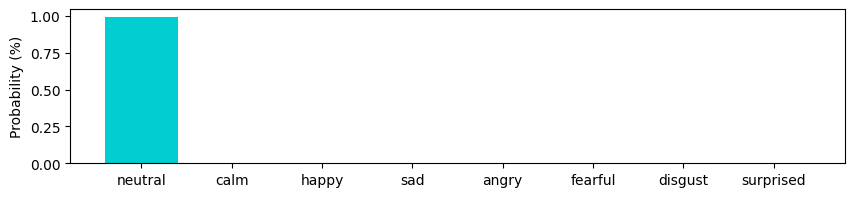

max emotion for chunk: neutral
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 34ms/step


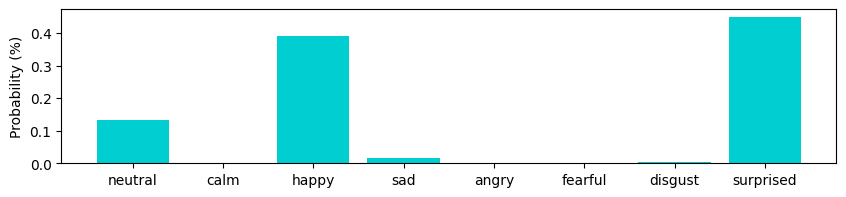

max emotion for chunk: surprised
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step


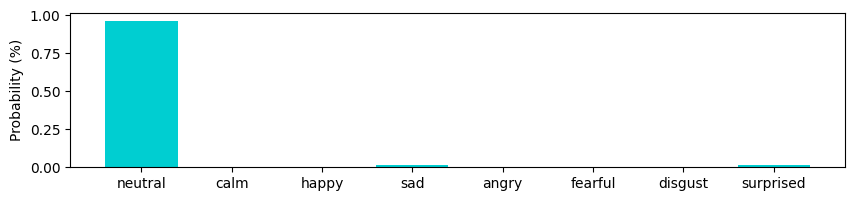

max emotion for chunk: neutral
----------------------------------------------------------------------------------------------------


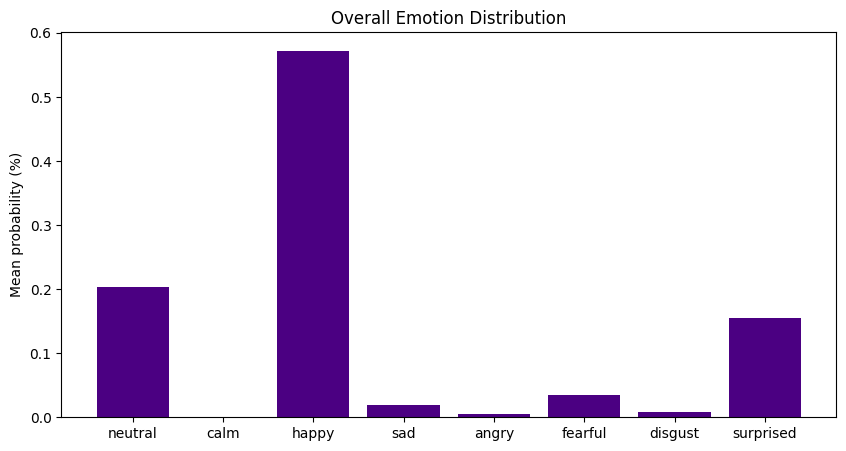

In [18]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Variables
FILE_PATH = './final_test/luke_long_1.wav'
SAMPLE_RATE = 24414  # Same as RATE in the original script
CHUNK_DURATION = 1  # Duration of chunks to analyze (in seconds)
emo_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]


# Function to split audio file into 1-second chunks and process each chunk
def process_audio_file(file_path):
    total_predictions = []  # List to store predictions for each chunk
    
    # Load audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Calculate the number of chunks
    num_chunks = int(np.floor(len(audio) / sr / CHUNK_DURATION))
    
    for i in range(num_chunks):
        # Extract the chunk
        start_sample = i * sr * CHUNK_DURATION
        end_sample = start_sample + sr * CHUNK_DURATION
        chunk = audio[start_sample:end_sample]
        
        # Save chunk to temporary WAV file
        chunk_file_path = 'temp_chunk.wav'
        sf.write(chunk_file_path, chunk, sr)
        
        # Preprocess the chunk
        x = preprocess(chunk_file_path)  # Ensure your preprocess function is adapted for handling the chunk
        
        # Model's prediction => an 8 emotion probabilities array
        predictions = model.predict(x, use_multiprocessing=True)
        pred_list = list(predictions)
        pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0)  # Simplify the predictions list
        total_predictions.append(pred_np)
        
        # Optionally, visualize the prediction for each chunk
        fig = plt.figure(figsize=(10, 2))
        plt.bar(emo_list, pred_np, color='darkturquoise')
        plt.ylabel("Probability (%)")
        plt.show()
        
        # Print the predominant emotion for the chunk
        max_emo = np.argmax(predictions)
        print('max emotion for chunk:', emo_list[max_emo])
        print(100 * '-')
    
    # After processing all chunks, calculate and visualize the mean prediction
    mean_predictions = np.mean(np.array(total_predictions), axis=0)
    fig = plt.figure(figsize=(10, 5))
    plt.bar(emo_list, mean_predictions, color='indigo')
    plt.ylabel("Mean probability (%)")
    plt.title("Overall Emotion Distribution")
    plt.show()

# Call the function to process the audio file
process_audio_file(FILE_PATH)
